# Classifying ALL with XGBoost using Optuna

## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.3/212.3 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.0 MB/s eta 0:00:00


## Dependencies

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import joblib

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.utils.fixes import loguniform

from scipy.stats import uniform, truncnorm, randint, loguniform

# Classification metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import f1_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score

# Function for creating model pipelines - imblearn
## from imblearn.pipeline import make_pipeline as imbl_pipe

# Over-sampling using SMOTE
## from imblearn.over_sampling import SMOTE

# Import XGBoost
from xgboost import XGBClassifier

# Import Optuna
import optuna

import warnings
warnings.filterwarnings('ignore')

random_state = 10

In [5]:
# Import the script from different folder
import sys  
sys.path.append('/content/drive/MyDrive/Omdena/Team1/scripts')

import metrics_utilities as mu

## Batch_1 Train Dataset

In [6]:
df_train = pd.read_pickle('/content/drive/MyDrive/Omdena/Team1/batch_1/train_data.pickle')
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.579951,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.166770,0.0,0.0,...,0.747650,0.245581,0.030024,0.174167,0.540283,0.0,0.0,0.353232,0.0,1
1,0.578539,0.0,0.059236,0.000000,0.000000,0.0,0.0,0.199044,0.0,0.0,...,0.668872,0.162014,0.000000,0.127915,0.493748,0.0,0.0,0.275539,0.0,1
2,0.087414,0.0,0.695490,0.436274,0.000000,0.0,0.0,0.103897,0.0,0.0,...,0.492471,0.082775,0.000000,0.112004,0.438546,0.0,0.0,0.096754,0.0,0
3,0.329184,0.0,0.000000,0.029938,0.024057,0.0,0.0,0.036206,0.0,0.0,...,0.654933,0.337055,0.000000,0.000000,0.346229,0.0,0.0,0.317232,0.0,0
4,0.053473,0.0,0.000000,0.184720,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.732901,0.191005,0.000000,0.049176,0.545555,0.0,0.0,0.281541,0.0,0


#### Separate features and labels

In [7]:
X_train = df_train.iloc[:, : -1]
y_train = df_train['label']
print(X_train.shape, y_train.shape)

(8528, 4608) (8528,)


## Batch_1 Test Dataset

In [8]:
df_test = pd.read_pickle('/content/drive/MyDrive/Omdena/Team1/batch_1/test_data.pickle')
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,4599,4600,4601,4602,4603,4604,4605,4606,4607,label
0,0.353652,0.0,0.000000,0.305203,0.0377,0.0,0.0,0.000000,0.0,0.0,...,0.728745,0.127965,0.0,0.000000,0.303071,0.0,0.0,0.028939,0.0,0
1,0.695522,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.104255,0.0,0.0,...,0.730706,0.220946,0.0,0.016399,0.487663,0.0,0.0,0.354154,0.0,1
2,0.279904,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.160006,0.0,0.0,...,0.676915,0.199919,0.0,0.062777,0.000000,0.0,0.0,0.000000,0.0,0
3,0.098326,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.172469,0.0,0.0,...,0.945252,0.119779,0.0,0.021867,0.614726,0.0,0.0,0.154880,0.0,0
4,0.270445,0.0,0.769334,0.022462,0.0000,0.0,0.0,0.000000,0.0,0.0,...,0.538275,0.242577,0.0,0.014566,0.438992,0.0,0.0,0.191071,0.0,0


#### Separate features and labels

In [9]:
X_test = df_test.iloc[:, :-1]
y_test = df_test['label']
print(X_test.shape, y_test.shape)

(2133, 4608) (2133,)


#### Names of Classes

In [10]:
target_names = ['all', 'hem']

# Fit the Base Model

In [ ]:
clf_xgb = XGBClassifier(tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)

In [ ]:
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
clf_xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'auc',
 'feature_types': None,
 'gamma': None,
 'gpu_id': 0,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': 10,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': 'gpu_hist',
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
# Save the model
joblib.dump(clf_xgb, '/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_base.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_base.save']

In [ ]:
y_pred = clf_xgb.predict(X_test)

In [ ]:
y_pred

array([0, 1, 0, ..., 0, 0, 1])

In [ ]:
accuracy_score(y_test, y_pred)

0.8321612751992499

In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8321612751992499


In [ ]:
confusion_matrix(y_test, y_pred)

array([[1352,  103],
       [ 255,  423]])

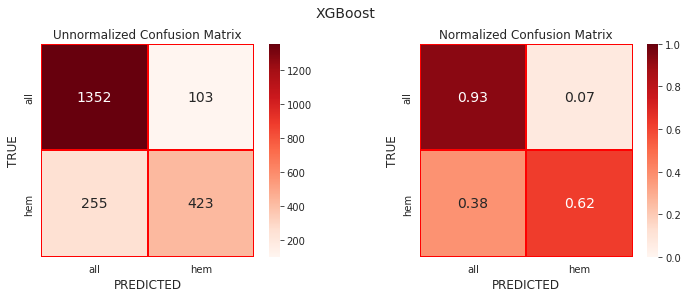

In [ ]:
# Plot confusion matrices
mu.plot_cm_unnorm_and_norm('XGBoost', y_test, y_pred, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

         all       0.84      0.93      0.88      1455
         hem       0.80      0.62      0.70       678

    accuracy                           0.83      2133
   macro avg       0.82      0.78      0.79      2133
weighted avg       0.83      0.83      0.83      2133



# Optuna - GPU #1

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
    }

    # Fit the model
    model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    ###  accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return f1

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-09 21:23:49,424] A new study created in memory with name: no-name-c91addef-a73d-4316-86de-39f776ca0f84


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-09 21:24:20,076] Trial 0 finished with value: 0.5510204081632653 and parameters: {'max_depth': 8, 'learning_rate': 0.4448379292060382, 'n_estimators': 434, 'min_child_weight': 8, 'gamma': 1.7845487217998776e-07, 'subsample': 0.146604284250699, 'colsample_bytree': 0.023740780117987238, 'reg_alpha': 2.848858430862753e-08, 'reg_lambda': 0.00041547767256577714}. Best is trial 0 with value: 0.5510204081632653.
[I 2023-04-09 21:24:49,192] Trial 1 finished with value: 0.6140845070422535 and parameters: {'max_depth': 9, 'learning_rate': 0.017393428032485357, 'n_estimators': 409, 'min_child_weight': 2, 'gamma': 0.23705775871109983, 'subsample': 0.27074161031676147, 'colsample_bytree': 0.013209563133614852, 'reg_alpha': 9.088017266702185e-07, 'reg_lambda': 0.002100539958062121}. Best is trial 1 with value: 0.6140845070422535.
[I 2023-04-09 21:24:58,748] Trial 2 finished with value: 0.4980392156862745 and parameters: {'max_depth': 3, 'learning_rate': 0.021769214028623265, 'n_estimators

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.7326892109500803
  Params: 
    max_depth: 9
    learning_rate: 0.2080303829670654
    n_estimators: 485
    min_child_weight: 10
    gamma: 1.6084150429259338e-05
    subsample: 0.7679767920974849
    colsample_bytree: 0.4341514369112176
    reg_alpha: 0.24436777726533185
    reg_lambda: 5.334351888074554e-08


## Re-fit the model

In [ ]:
params = trial.params

clf_xgb_opt = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4341514369112176, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1.6084150429259338e-05, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2080303829670654, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=485, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
# Save the model
joblib.dump(clf_xgb_opt, '/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_1.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_1.save']

In [ ]:
y_pred_opt = clf_xgb_opt.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 84.44


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb_opt.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb_opt.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8443506797937178


In [ ]:
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

[[1346  109]
 [ 223  455]]


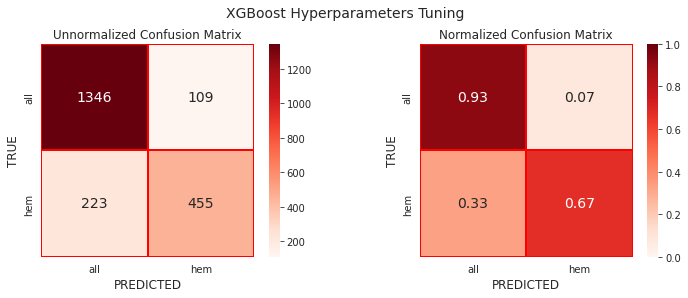

In [ ]:
# Plot confusion matrix and its normalized version.
target_names = ['all', 'hem']
mu.plot_cm_unnorm_and_norm('XGBoost Hyperparameters Tuning', y_test, y_pred_opt, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_opt, target_names=target_names))

              precision    recall  f1-score   support

         all       0.86      0.93      0.89      1455
         hem       0.81      0.67      0.73       678

    accuracy                           0.84      2133
   macro avg       0.83      0.80      0.81      2133
weighted avg       0.84      0.84      0.84      2133



# Optuna GPU #2

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 12), # changed
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 600), # changed
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 12), # changed
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    ###  accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return f1

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-09 22:47:48,139] A new study created in memory with name: no-name-a738ff23-7792-4bdb-9c35-f43ba65029a1


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-09 22:48:12,514] Trial 0 finished with value: 0.5458612975391499 and parameters: {'max_depth': 4, 'learning_rate': 0.3331822474371084, 'n_estimators': 261, 'min_child_weight': 12, 'gamma': 1.4867891037926383e-06, 'subsample': 0.033559533659801265, 'colsample_bytree': 0.08798356951744415, 'reg_alpha': 0.00012986392962708213, 'reg_lambda': 2.2544410109995342e-07}. Best is trial 0 with value: 0.5458612975391499.
[I 2023-04-09 22:48:22,254] Trial 1 finished with value: 0.5738515901060071 and parameters: {'max_depth': 11, 'learning_rate': 0.8167027830148739, 'n_estimators': 130, 'min_child_weight': 11, 'gamma': 5.8672709031307364e-05, 'subsample': 0.1728693180880522, 'colsample_bytree': 0.24982451601881545, 'reg_alpha': 5.6093448808607235e-05, 'reg_lambda': 1.2088761119068074e-05}. Best is trial 1 with value: 0.5738515901060071.
[I 2023-04-09 22:48:30,197] Trial 2 finished with value: 0.5321955003878975 and parameters: {'max_depth': 9, 'learning_rate': 0.19992791490406323, 'n_est

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.7401960784313726
  Params: 
    max_depth: 9
    learning_rate: 0.11152989896408123
    n_estimators: 474
    min_child_weight: 12
    gamma: 6.833890002694324e-07
    subsample: 0.9953191841383607
    colsample_bytree: 0.7144434954277856
    reg_alpha: 0.0017187365907499281
    reg_lambda: 0.9003955735359669


## Re-fit the model

In [ ]:
params = trial.params

clf_xgb_opt = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7144434954277856, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=6.833890002694324e-07, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.11152989896408123, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=12, missing=nan, monotone_constraints=None,
              n_estimators=474, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
# Save the model
joblib.dump(clf_xgb_opt, '/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_2.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_2.save']

In [ ]:
y_pred_opt = clf_xgb_opt.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 85.09


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb_opt.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb_opt.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8509142053445851


In [ ]:
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

[[1362   93]
 [ 225  453]]


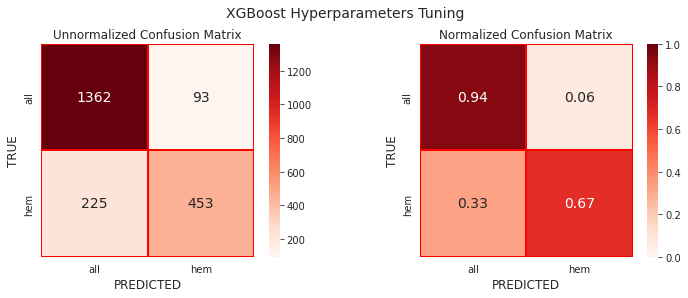

In [ ]:
# Plot confusion matrix and its normalized version.
target_names = ['all', 'hem']
mu.plot_cm_unnorm_and_norm('XGBoost Hyperparameters Tuning', y_test, y_pred_opt, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_opt, target_names=target_names))

              precision    recall  f1-score   support

         all       0.86      0.94      0.90      1455
         hem       0.83      0.67      0.74       678

    accuracy                           0.85      2133
   macro avg       0.84      0.80      0.82      2133
weighted avg       0.85      0.85      0.85      2133



# Optuna GPU #3

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 14), # changed
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 700), # changed
        'min_child_weight': trial.suggest_int('min_child_weight', 4, 16), # changed
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    ###  accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return f1

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-10 00:52:55,278] A new study created in memory with name: no-name-cb0e971e-caa6-4932-9aec-b589ff57306f


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-10 00:53:28,991] Trial 0 finished with value: 0.6408268733850129 and parameters: {'max_depth': 10, 'learning_rate': 0.019511631869859113, 'n_estimators': 654, 'min_child_weight': 12, 'gamma': 2.4474562574725535e-08, 'subsample': 0.04594275304766919, 'colsample_bytree': 0.8287751938731378, 'reg_alpha': 1.1765639472022775e-08, 'reg_lambda': 0.00037307953220044014}. Best is trial 0 with value: 0.6408268733850129.
[I 2023-04-10 00:53:52,357] Trial 1 finished with value: 0.5880681818181818 and parameters: {'max_depth': 14, 'learning_rate': 0.1950243577162825, 'n_estimators': 375, 'min_child_weight': 5, 'gamma': 0.0008625065497491111, 'subsample': 0.08643166381121906, 'colsample_bytree': 0.8616000549722392, 'reg_alpha': 0.00015756191950757456, 'reg_lambda': 6.085776267136656e-05}. Best is trial 0 with value: 0.6408268733850129.
[I 2023-04-10 00:54:09,962] Trial 2 finished with value: 0.5862393967954759 and parameters: {'max_depth': 11, 'learning_rate': 0.013159454844956304, 'n_est

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.7404326123128121
  Params: 
    max_depth: 8
    learning_rate: 0.08184891148614436
    n_estimators: 692
    min_child_weight: 8
    gamma: 2.896297389535072e-05
    subsample: 0.8597640464550312
    colsample_bytree: 0.6437150102579825
    reg_alpha: 5.7892345066756324e-06
    reg_lambda: 5.768892832665605e-07


## Re-fit the model

In [ ]:
params = trial.params

clf_xgb_opt = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6437150102579825, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2.896297389535072e-05, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08184891148614436, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              n_estimators=692, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
# Save the model
joblib.dump(clf_xgb_opt, '/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_3.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_3.save']

In [ ]:
y_pred_opt = clf_xgb_opt.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 85.37


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb_opt.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb_opt.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8537271448663853


In [ ]:
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

[[1376   79]
 [ 233  445]]


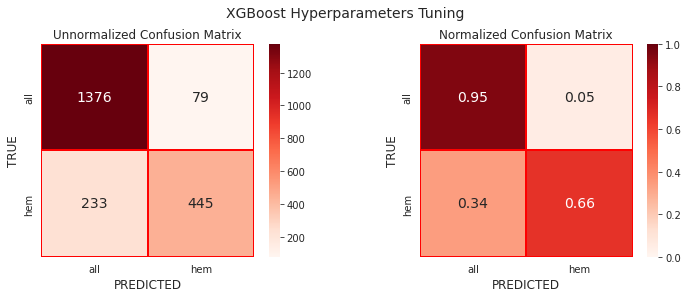

In [ ]:
# Plot confusion matrix and its normalized version.
target_names = ['all', 'hem']
mu.plot_cm_unnorm_and_norm('XGBoost Hyperparameters Tuning', y_test, y_pred_opt, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_opt, target_names=target_names))

              precision    recall  f1-score   support

         all       0.86      0.95      0.90      1455
         hem       0.85      0.66      0.74       678

    accuracy                           0.85      2133
   macro avg       0.85      0.80      0.82      2133
weighted avg       0.85      0.85      0.85      2133



# Optuna GPU #4

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 8, 14), # changed
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators',300, 750), # changed
        'min_child_weight': trial.suggest_int('min_child_weight', 8, 16), # changed
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate predictions
    ###  accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return f1

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-10 15:04:10,623] A new study created in memory with name: no-name-c1a1584d-fa42-4a9b-b067-ca78d82d9384


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-10 15:04:29,623] Trial 0 finished with value: 0.516507703595011 and parameters: {'max_depth': 12, 'learning_rate': 0.6484288227327636, 'n_estimators': 377, 'min_child_weight': 8, 'gamma': 1.1477582757772902e-07, 'subsample': 0.0579355648001657, 'colsample_bytree': 0.2331698393632042, 'reg_alpha': 6.058523080860691e-08, 'reg_lambda': 1.1154772014045993e-07}. Best is trial 0 with value: 0.516507703595011.
[I 2023-04-10 15:04:43,330] Trial 1 finished with value: 0.6855241264559069 and parameters: {'max_depth': 13, 'learning_rate': 0.03695559957231757, 'n_estimators': 627, 'min_child_weight': 12, 'gamma': 2.0332836114670994e-08, 'subsample': 0.20251338172174263, 'colsample_bytree': 0.1428409491137157, 'reg_alpha': 3.179668414845631e-08, 'reg_lambda': 1.0106098165849272e-08}. Best is trial 1 with value: 0.6855241264559069.
[I 2023-04-10 15:04:51,734] Trial 2 finished with value: 0.6160409556313993 and parameters: {'max_depth': 11, 'learning_rate': 0.04091054583933655, 'n_estimato

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.7353668590272053
  Params: 
    max_depth: 12
    learning_rate: 0.14426335858709802
    n_estimators: 639
    min_child_weight: 14
    gamma: 0.01179156572052015
    subsample: 0.9058039760247653
    colsample_bytree: 0.325923207198522
    reg_alpha: 3.2324929656100853e-07
    reg_lambda: 3.482541355923775e-08


## Re-fit the model

In [ ]:
params = trial.params

clf_xgb_opt = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.325923207198522, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.01179156572052015, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.14426335858709802, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=14, missing=nan, monotone_constraints=None,
              n_estimators=639, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
# Save the model
joblib.dump(clf_xgb_opt, '/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_4.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_4.save']

In [ ]:
y_pred_opt = clf_xgb_opt.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 84.95


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb_opt.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb_opt.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.849507735583685


In [ ]:
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

[[1366   89]
 [ 232  446]]


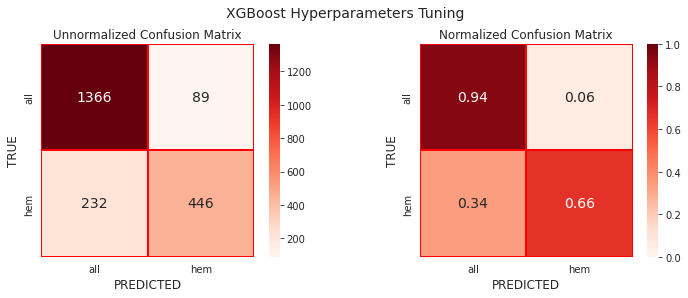

In [ ]:
# Plot confusion matrix and its normalized version.
target_names = ['all', 'hem']
mu.plot_cm_unnorm_and_norm('XGBoost Hyperparameters Tuning', y_test, y_pred_opt, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_opt, target_names=target_names))

              precision    recall  f1-score   support

         all       0.86      0.95      0.90      1455
         hem       0.85      0.66      0.74       678

    accuracy                           0.85      2133
   macro avg       0.85      0.80      0.82      2133
weighted avg       0.85      0.85      0.85      2133



# Optuna GPU & CV3-mean #5

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 14), # changed
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 700), # changed
        'min_child_weight': trial.suggest_int('min_child_weight', 4, 16), # changed
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
    # model.fit(X_train, y_train)

    # # Make predictions
    # y_pred = model.predict(X_test)

    # # Evaluate predictions
    # ###  accuracy = accuracy_score(y_test, y_pred)
    # f1 = f1_score(y_test, y_pred)
    # return f1

return cross_val_score(model, X_train, y_train, scoring='f1', cv=3).mean()

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-10 15:31:52,104] A new study created in memory with name: no-name-815d7644-f81d-4efe-b813-03c7fb325457


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-10 15:32:24,088] Trial 0 finished with value: 0.523313074302261 and parameters: {'max_depth': 8, 'learning_rate': 0.20612258936456093, 'n_estimators': 554, 'min_child_weight': 11, 'gamma': 1.140846862194345e-05, 'subsample': 0.028827150197264877, 'colsample_bytree': 0.06720260713474008, 'reg_alpha': 2.3585132023494402e-07, 'reg_lambda': 8.379865722981544e-07}. Best is trial 0 with value: 0.523313074302261.
[I 2023-04-10 15:32:57,648] Trial 1 finished with value: 0.619452334056325 and parameters: {'max_depth': 4, 'learning_rate': 0.2193905130122531, 'n_estimators': 635, 'min_child_weight': 10, 'gamma': 2.070753693312433e-06, 'subsample': 0.31938973995926345, 'colsample_bytree': 0.04018408361085531, 'reg_alpha': 0.00024202496229462126, 'reg_lambda': 1.7426336107461652e-07}. Best is trial 1 with value: 0.619452334056325.
[I 2023-04-10 15:33:11,378] Trial 2 finished with value: 0.5087662064836144 and parameters: {'max_depth': 5, 'learning_rate': 0.5640320470404472, 'n_estimators

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.6671294975978729
  Params: 
    max_depth: 13
    learning_rate: 0.08480612661800419
    n_estimators: 626
    min_child_weight: 14
    gamma: 4.051210202947519e-07
    subsample: 0.726994231538908
    colsample_bytree: 0.34940485938711324
    reg_alpha: 3.5269801256540457e-07
    reg_lambda: 1.6579513184315743e-08


## Re-fit the model

In [ ]:
params = trial.params

clf_xgb_opt = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.34940485938711324, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=4.051210202947519e-07, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.08480612661800419, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=14, missing=nan, monotone_constraints=None,
              n_estimators=626, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
# Save the model
joblib.dump(clf_xgb_opt, '/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_5.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_5.save']

In [ ]:
y_pred_opt = clf_xgb_opt.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 83.97


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb_opt.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb_opt.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8396624472573839


In [ ]:
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

[[1357   98]
 [ 244  434]]


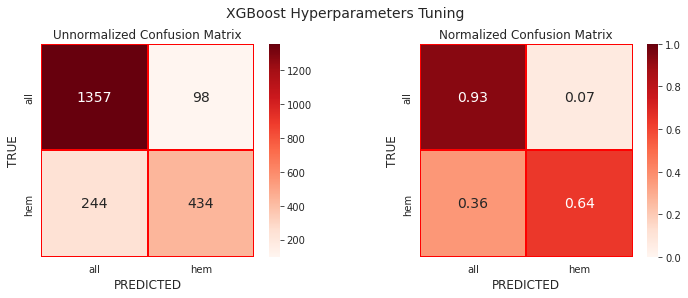

In [ ]:
# Plot confusion matrix and its normalized version.
target_names = ['all', 'hem']
mu.plot_cm_unnorm_and_norm('XGBoost Hyperparameters Tuning', y_test, y_pred_opt, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_opt, target_names=target_names))

              precision    recall  f1-score   support

         all       0.85      0.93      0.89      1455
         hem       0.82      0.64      0.72       678

    accuracy                           0.84      2133
   macro avg       0.83      0.79      0.80      2133
weighted avg       0.84      0.84      0.83      2133



# Optuna GPU & CV5-mean #6

## Optuna Objective Function

In [ ]:
def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 4, 14), # changed
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 700), # changed
        'min_child_weight': trial.suggest_int('min_child_weight', 4, 16), # changed
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
    }

    # Fit the model
    model = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
    # model.fit(X_train, y_train)

    # # Make predictions
    # y_pred = model.predict(X_test)

    # # Evaluate predictions
    # ###  accuracy = accuracy_score(y_test, y_pred)
    # f1 = f1_score(y_test, y_pred)
    # return f1

    return cross_val_score(model, X_train, y_train, scoring='f1', cv=5).mean()

## Optuna Study

In [ ]:
study = optuna.create_study(direction='maximize')

[I 2023-04-11 22:43:21,010] A new study created in memory with name: no-name-bdb03aee-a70c-496c-804d-835ff42ccbb1


## Optimize the Objective Function

In [ ]:
study.optimize(objective, n_trials=100)

[I 2023-04-11 22:44:09,681] Trial 0 finished with value: 0.5993375689658033 and parameters: {'max_depth': 4, 'learning_rate': 0.01748964756746165, 'n_estimators': 409, 'min_child_weight': 16, 'gamma': 0.00037847388731994717, 'subsample': 0.3475239749035439, 'colsample_bytree': 0.8193219206093248, 'reg_alpha': 2.3508517726165995e-06, 'reg_lambda': 2.3961243462714656e-05}. Best is trial 0 with value: 0.5993375689658033.
[I 2023-04-11 22:44:46,603] Trial 1 finished with value: 0.432339935773432 and parameters: {'max_depth': 6, 'learning_rate': 0.11182813470427691, 'n_estimators': 413, 'min_child_weight': 10, 'gamma': 5.9296285850047424e-08, 'subsample': 0.012980331135948459, 'colsample_bytree': 0.3013771557279358, 'reg_alpha': 1.4990888273452992e-07, 'reg_lambda': 5.727710617089161e-07}. Best is trial 0 with value: 0.5993375689658033.
[I 2023-04-11 22:45:30,862] Trial 2 finished with value: 0.5761211655573775 and parameters: {'max_depth': 9, 'learning_rate': 0.014727059171741993, 'n_estim

## Best Parameters

In [ ]:
print(f'Number of finished trials: {len(study.trials)}')
print('Best trial:')
trial = study.best_trial

print(f'  Value: {trial.value}')
print('  Params: ')

for key, value in trial.params.items():
    print(f'    {key}: {value}')

Number of finished trials: 100
Best trial:
  Value: 0.6780320451201585
  Params: 
    max_depth: 13
    learning_rate: 0.11230675847223504
    n_estimators: 658
    min_child_weight: 15
    gamma: 2.3566217636827177e-08
    subsample: 0.7491256519760777
    colsample_bytree: 0.08389210332604456
    reg_alpha: 2.21928329604209e-05
    reg_lambda: 2.787111357035394e-06


## Re-fit the model

In [ ]:
params = trial.params

clf_xgb_opt = XGBClassifier(**params, tree_method='gpu_hist', gpu_id=0, objective='binary:logistic', eval_metric='auc', random_state=random_state)
clf_xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.08389210332604456, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=2.3566217636827177e-08, gpu_id=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.11230675847223504, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=13, max_leaves=None,
              min_child_weight=15, missing=nan, monotone_constraints=None,
              n_estimators=658, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=10, ...)

In [ ]:
# Save the model
joblib.dump(clf_xgb_opt, '/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_6.save')

['/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_6.save']

In [ ]:
y_pred_opt = clf_xgb_opt.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred_opt)
print(f'Accuracy after tuning: {accuracy * 100.0:.2f}')

Accuracy after tuning: 83.92


In [ ]:
# Compare training and testing scores
print(f"Training Data Score: {clf_xgb_opt.score(X_train, y_train)}")
print(f"Testing Data Score: {clf_xgb_opt.score(X_test, y_test)}")

Training Data Score: 1.0
Testing Data Score: 0.8391936240037506


In [ ]:
cm = confusion_matrix(y_test, y_pred_opt)
print(cm)

[[1352  103]
 [ 240  438]]


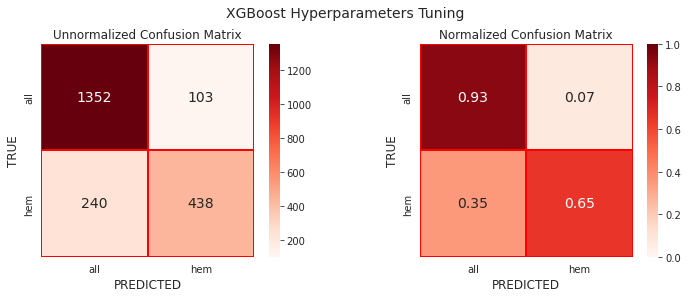

In [ ]:
# Plot confusion matrix and its normalized version.
target_names = ['all', 'hem']
mu.plot_cm_unnorm_and_norm('XGBoost Hyperparameters Tuning', y_test, y_pred_opt, target_names, 'Reds')

In [ ]:
print(classification_report(y_test, y_pred_opt, target_names=target_names))

              precision    recall  f1-score   support

         all       0.85      0.93      0.89      1455
         hem       0.81      0.65      0.72       678

    accuracy                           0.84      2133
   macro avg       0.83      0.79      0.80      2133
weighted avg       0.84      0.84      0.83      2133



# Comparison

In [ ]:
xgb = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_base.save')
y_pred_base = xgb.predict(X_test)
xgb_opt1 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_1.save')
y_pred1 = xgb_opt1.predict(X_test)
xgb_opt2 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_2.save')
y_pred2 = xgb_opt2.predict(X_test)
xgb_opt3 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_3.save')
y_pred3 = xgb_opt3.predict(X_test)
xgb_opt4 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_4.save')
y_pred4 = xgb_opt4.predict(X_test)
xgb_opt5 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_5.save')
y_pred5 = xgb_opt5.predict(X_test)
xgb_opt6 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_6.save')
y_pred6 = xgb_opt6.predict(X_test)
# From my laptop
y_pred_rs = np.load('/content/drive/MyDrive/Omdena/Team1/saved_models/y_pred_rs.npy')

In [ ]:
pred_d = {'XGBoost - Base' : y_pred_base,
          'XGBoost Optuna #1' : y_pred1,
          'XGBoost - Optuna #2' : y_pred2,
          'XGBoost - Optuna #3' : y_pred3,
          'XGBoost - Optuna #4' : y_pred4,
          'XGBoost - Optuna CV3-mean #5' : y_pred5,
          'XGBoost - Optuna CV5-mean #6' : y_pred6,
          'XGBoost - RandomizedSearchCV3' : y_pred_rs
}

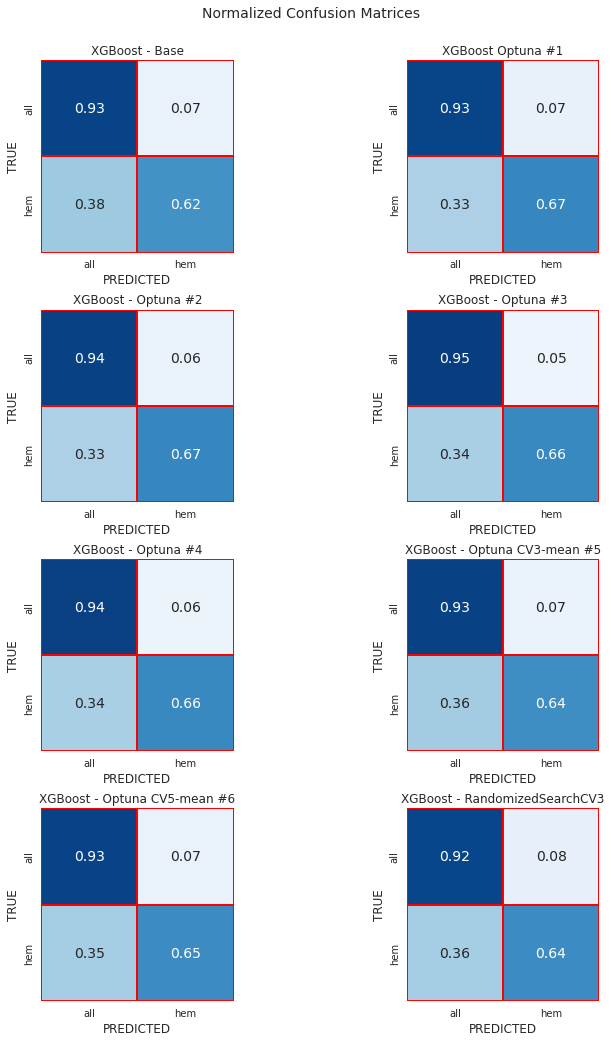

In [ ]:
# Plot all confusion matrices - normalized
mu.plot_conf_matrices(pred_d, y_test, target_names, 'Blues')

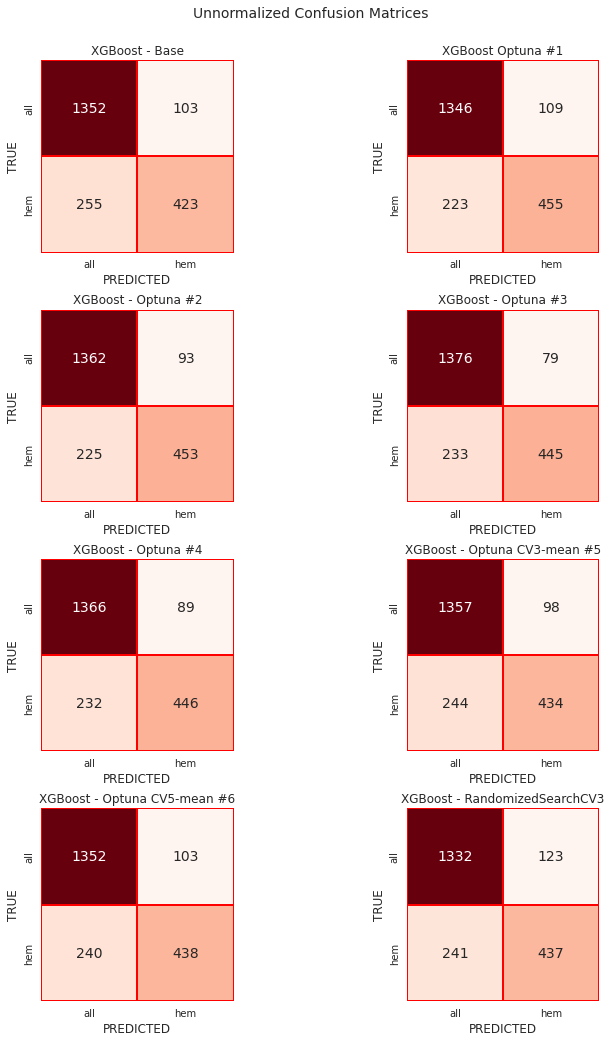

In [ ]:
# Plot all confusion matrices - unnormalized
mu.plot_conf_matrices(pred_d, y_test, target_names, 'Reds', norm=False)

## Plot ROC Curves

In [11]:
# Load best performing models
xgb_opt2 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_2.save')
xgb_opt3 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_3.save')
xgb_opt4 = joblib.load('/content/drive/MyDrive/Omdena/Team1/saved_models/clf_xgb_opt_4.save')

In [12]:
# Best performing models dictionary
best_models = {'XGBoost - Optuna #2' : xgb_opt2,
          'XGBoost - Optuna #3' : xgb_opt3,
          'XGBoost - Optuna #4' : xgb_opt4
}

#### Create function to plot ROC curves for train and test data

In [30]:
def plot_roc_curves(model_name, model, batch, X_train, X_test, y_train, y_test):
    fig, [ax_train, ax_test] = plt.subplots(1, 2, figsize=(11, 5))
    fig.suptitle(f'{model_name}', fontsize=14)
    
    pred_train = model.predict(X_train)
    pred_test= model.predict(X_test)
    auc_train = roc_auc_score(y_train, pred_train)
    auc_test = roc_auc_score(y_test, pred_test)
    fpr_train, tpr_train, _ = roc_curve(y_train, pred_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, pred_test)

    ax_train.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
    ax_test.plot([0, 1], [0, 1], 'r--', label='Random Guessing')

    ax_train.plot(fpr_train, tpr_train, label=f'{model_name} (AUC: {auc_train:.2f})')
    ax_test.plot(fpr_test, tpr_test, label=f'{model_name} (AUC: {auc_test:.4f})')

    ax_train.set_title(f'ROC curve - Train Data - {batch}')
    ax_test.set_title(f'ROC curve - Test Data- {batch}')
                    
    ax_train.set_xlabel('False positive rate')
    ax_test.set_xlabel('False positive rate')

    ax_train.set_ylabel('True positive rate')
    ax_test.set_ylabel('True positive rate')

    ax_train.legend(loc='best')
    ax_test.legend(loc='best')

    plt.show()
    print()

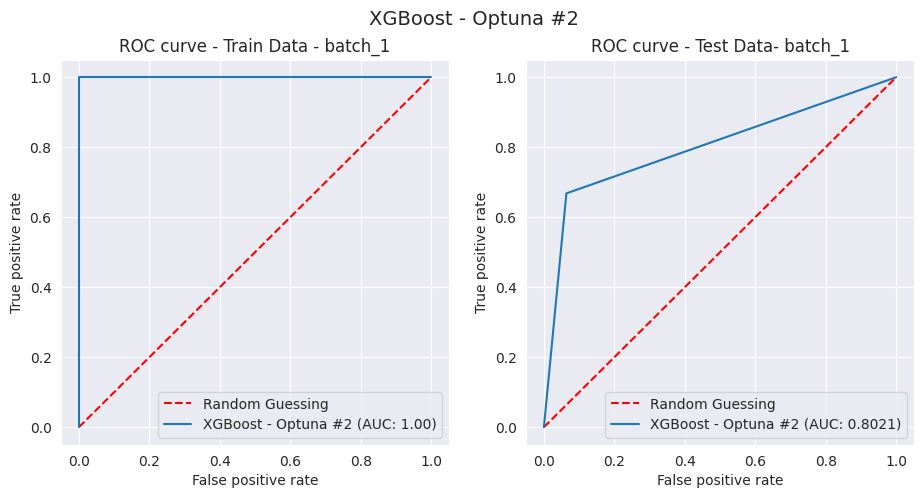

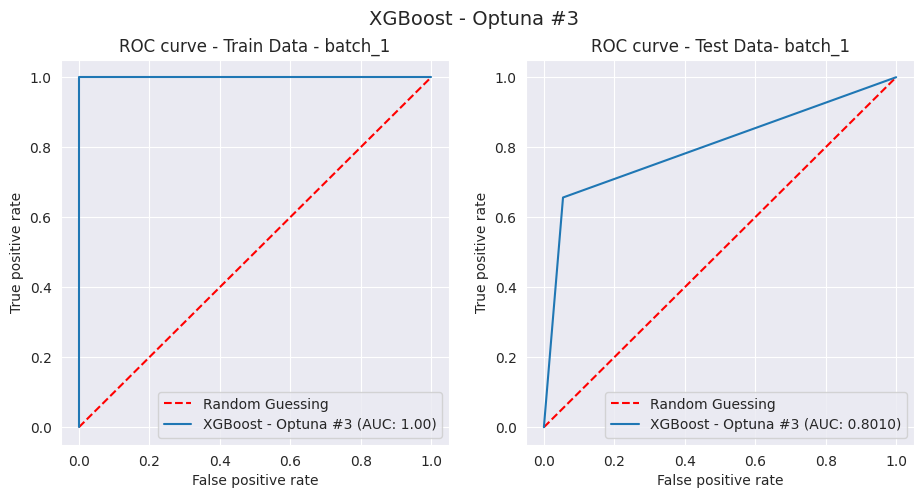

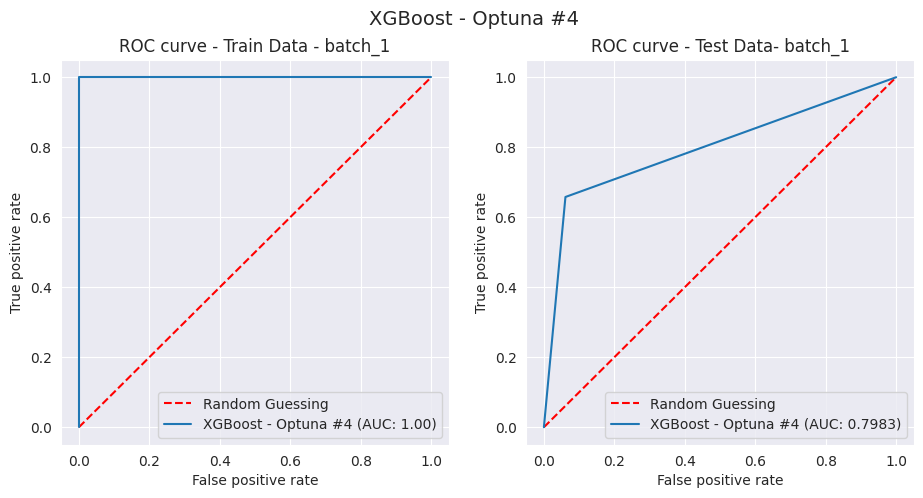

In [31]:
# Plot ROC curves for each of best performing models
for mn, m in best_models.items():
    plot_roc_curves(mn, m, 'batch_1', X_train, X_test, y_train, y_test)